In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression
from sklearn.linear_model import LassoCV, Lasso
from sklearn.feature_selection import VarianceThreshold

In [2]:
data = pd.read_csv('/kaggle/input/pubchem-fingerprint-3/pubchem_fingerprint (3).csv')
data

,Unnamed: 0.1,Unnamed: 0,canonical_smiles,standard_relation,standard_type,standard_units,pIC50,pubchem_fingerprint
0,13,27,CC(C)(C)NCc1cc(Nc2ccnc3cc(Cl)ccc23)cc(-c2ccc(C...,=,IC50,nM,7.236572,[1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0...
1,14,28,CC(C)(C)NCc1cc(Nc2ccnc3cc(Cl)ccc23)cc(-c2ccc(C...,=,IC50,nM,7.130768,[1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0...
2,20,38,C[C@H]1[C@@H](OCCCONC(=O)c2ccccc2O)O[C@@H]2O[C...,=,IC50,nM,7.280255,[1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0...
3,33,66,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,=,IC50,nM,6.602060,[1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0...
4,45,87,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,=,IC50,nM,6.602060,[1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0...
...,...,...,...,...,...,...,...,...
22630,45226,969209,CC1(N2CCC2)CCC(NCC2CCN(Cc3ccccc3)C2)CC1,=,IC50,nM,5.823909,[1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0...
22631,45227,969210,O=C(NC1CCN(CCOc2ccc(Cl)cc2)CC1)c1c[nH]c2ccncc2...,=,IC50,nM,5.698970,[1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0...
22632,45228,969211,COc1ccc(-c2cncc(C(=O)NCC3CCN(CCN(C)C)CC3)c2)cc1,=,IC50,nM,5.568636,[1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0...
22633,45229,969212,Cc1c(CN2CCC(O)(Cn3ccnc3)CC2)[nH]c2c(Cl)cccc12,=,IC50,nM,5.443697,[1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0...


In [3]:
def cleaning_fingerprint(smiles):
    fingerprint_list = []
    
    for data in smiles['pubchem_fingerprint']:
        if pd.isna(data):  
            continue
        cleaned_data = data.replace("[", "").replace("\n", "").replace("]", "").split()
        fingerprint_list.append(list(map(int, cleaned_data)))
    
    fingerprint_column = pd.DataFrame(fingerprint_list)
    fingerprint_column.columns = [f'bit{i}' for i in range(fingerprint_column.shape[1])]
    fingerprint_column = fingerprint_column.dropna().astype(int)
    fingerprint_column["pIC50"] = smiles["pIC50"].reset_index(drop=True)
    
    return fingerprint_column

In [4]:
fingerprint_final = (cleaning_fingerprint(data))
fingerprint_final

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit872,bit873,bit874,bit875,bit876,bit877,bit878,bit879,bit880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.236572
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.130768
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.280255
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.602060
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.602060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22630,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.823909
22631,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.698970
22632,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.568636
22633,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.443697


In [5]:
fingerprint_final.to_csv("PubchemFp-new-FULL.csv")

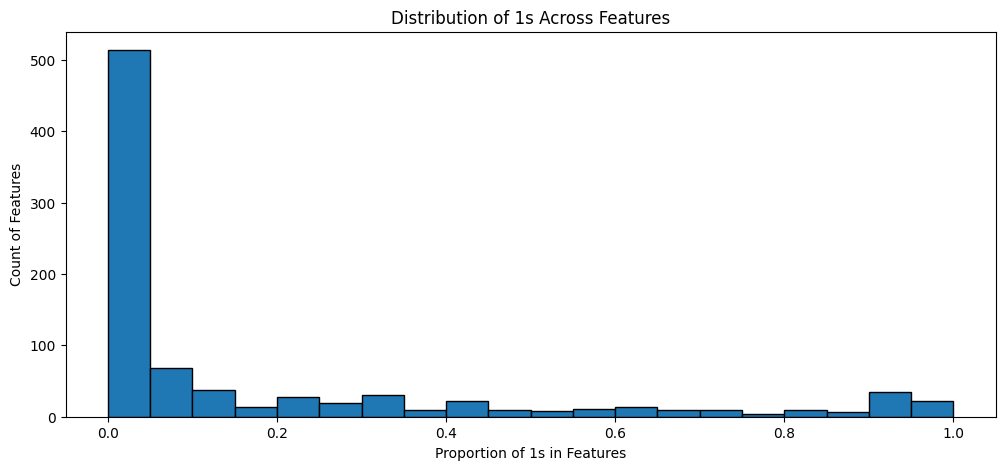

In [6]:
feature_counts = fingerprint_final.drop(columns=["pIC50"]).sum() / len(fingerprint_final)

plt.figure(figsize=(12, 5))
plt.hist(feature_counts, bins=20, edgecolor="black")
plt.xlabel("Proportion of 1s in Features")
plt.ylabel("Count of Features")
plt.title("Distribution of 1s Across Features")
plt.show()

In [7]:
fingerprint_p = fingerprint_final.drop(['pIC50'],axis=1)
fingerprint_p

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit871,bit872,bit873,bit874,bit875,bit876,bit877,bit878,bit879,bit880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22630,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
22631,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
22632,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
22633,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
selector = VarianceThreshold(threshold=0.05)
data_filter = selector.fit_transform(fingerprint_p)
selected_columns = fingerprint_p.columns[selector.get_support()]
X_df_selected = pd.DataFrame(data_filter, columns=selected_columns)
X_df_selected

,bit2,bit3,bit12,bit13,bit14,bit15,bit16,bit18,bit19,bit20,...,bit797,bit798,bit800,bit805,bit813,bit818,bit819,bit821,bit824,bit833
0,1,0,1,0,1,1,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0
1,1,0,1,0,1,1,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0
2,1,1,1,0,1,0,0,1,1,1,...,1,1,0,0,0,1,1,0,0,0
3,1,0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22572,1,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22573,1,0,1,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
22574,1,1,1,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
22575,1,0,1,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


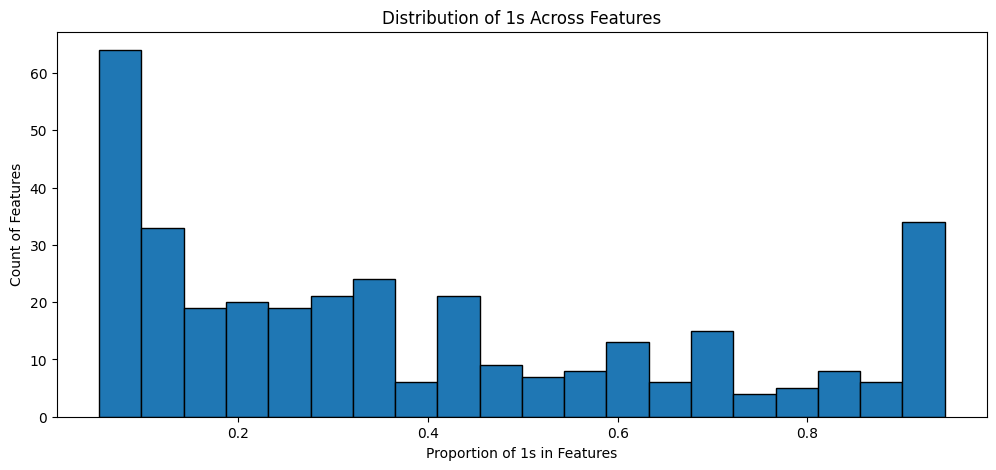

In [9]:
 feature_counts_2 = X_df_selected.sum() / len(data)
 plt.figure(figsize=(12, 5))
 plt.hist(feature_counts_2, bins=20, edgecolor="black")
 plt.xlabel("Proportion of 1s in Features")
 plt.ylabel("Count of Features")
 plt.title("Distribution of 1s Across Features")
 plt.show()

In [10]:
X = X_df_selected
y = fingerprint_final['pIC50']
feature_names = X.columns.tolist()

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)

In [12]:
lasso_cv = LassoCV(cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train, y_train)

# Ambil alpha terbaik
best_alpha = lasso_cv.alpha_
print(f"Alpha terbaik: {best_alpha}")

# Fit ulang dengan alpha terbaik
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)

# Simpan koefisien ke file
df_coef = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lasso.coef_
})
df_coef.to_csv("lasso_tuned_coefficients.csv", index=False)

# Simpan semua alpha dan MSE-nya
mean_mse = lasso_cv.mse_path_.mean(axis=1)
alphas = lasso_cv.alphas_

df_alphas = pd.DataFrame({
    "alpha": alphas,
    "mean_mse": mean_mse
})

# Tambahkan MSE per fold
for i in range(lasso_cv.mse_path_.shape[1]):
    df_alphas[f"mse_fold_{i+1}"] = lasso_cv.mse_path_[:, i]

df_alphas.to_csv("lasso_alpha_tuning_results.csv", index=False)

# 🔍 Cetak 5 alpha terbaik berdasarkan mean MSE terkecil
sorted_indices = np.argsort(mean_mse)
top_5_alphas = alphas[sorted_indices[:5]]

print("\n5 alpha terbaik berdasarkan MSE rata-rata:")
for i, idx in enumerate(sorted_indices[:5], 1):
    print(f"{i}. Alpha = {alphas[idx]:.6f}, Mean MSE = {mean_mse[idx]:.6f}")

Alpha terbaik: 8.934228636341257e-05

5 alpha terbaik berdasarkan MSE rata-rata:
1. Alpha = 0.000089, Mean MSE = 0.247063
2. Alpha = 0.000083, Mean MSE = 0.247064
3. Alpha = 0.000096, Mean MSE = 0.247066
4. Alpha = 0.000078, Mean MSE = 0.247068
5. Alpha = 0.000072, Mean MSE = 0.247073


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.938e+02, tolerance: 4.954e-01
  model = cd_fast.enet_coordinate_descent(


In [13]:
selected_features = df_coef[df_coef["coefficient"] != 0]["feature"].tolist()
print(f"\nJumlah fitur terpilih: {len(selected_features)}")
print("Fitur terpilih:")
print(selected_features)

pd.Series(selected_features, name="selected_feature").to_csv("selected_features.csv", index=False)


Jumlah fitur terpilih: 293
Fitur terpilih:
['bit2', 'bit3', 'bit12', 'bit13', 'bit15', 'bit16', 'bit18', 'bit19', 'bit20', 'bit21', 'bit23', 'bit24', 'bit33', 'bit37', 'bit38', 'bit143', 'bit145', 'bit150', 'bit152', 'bit153', 'bit179', 'bit180', 'bit181', 'bit185', 'bit186', 'bit187', 'bit188', 'bit192', 'bit193', 'bit194', 'bit195', 'bit199', 'bit200', 'bit206', 'bit241', 'bit243', 'bit244', 'bit248', 'bit249', 'bit250', 'bit251', 'bit255', 'bit257', 'bit258', 'bit261', 'bit262', 'bit287', 'bit293', 'bit294', 'bit299', 'bit300', 'bit308', 'bit335', 'bit337', 'bit338', 'bit339', 'bit340', 'bit341', 'bit342', 'bit345', 'bit346', 'bit351', 'bit352', 'bit353', 'bit355', 'bit356', 'bit357', 'bit358', 'bit359', 'bit363', 'bit364', 'bit366', 'bit367', 'bit368', 'bit371', 'bit372', 'bit373', 'bit374', 'bit375', 'bit376', 'bit377', 'bit378', 'bit379', 'bit380', 'bit381', 'bit382', 'bit384', 'bit385', 'bit386', 'bit387', 'bit389', 'bit390', 'bit391', 'bit392', 'bit393', 'bit395', 'bit396', 'b

In [14]:
df_nonzero = df_coef[df_coef["coefficient"] != 0].copy()
df_nonzero["abs_coef"] = df_nonzero["coefficient"].abs()
df_sorted = df_nonzero.sort_values(by="abs_coef", ascending=False)

n_total = len(df_sorted)
n_25 = max(1, int(n_total * 0.25))
n_50 = max(1, int(n_total * 0.50))
n_75 = max(1, int(n_total * 0.75))
n_100 = max(1, int(n_total * 1))

top_25_features = df_sorted.head(n_25)["feature"].tolist()
top_50_features = df_sorted.head(n_50)["feature"].tolist()
top_75_features = df_sorted.head(n_75)["feature"].tolist()
top_100_features = df_sorted.head(n_100)["feature"].tolist()

print(f"\nTop 25% fitur: ({n_25} fitur)\n", top_25_features)
print(f"\nTop 50% fitur: ({n_50} fitur)\n", top_50_features)
print(f"\nTop 75% fitur: ({n_75} fitur)\n", top_75_features)
print(f"\nTop 100% fitur: ({n_100} fitur)\n", top_100_features)



Top 25% fitur: (73 fitur)
 ['bit504', 'bit761', 'bit572', 'bit467', 'bit591', 'bit406', 'bit367', 'bit372', 'bit384', 'bit376', 'bit658', 'bit644', 'bit251', 'bit824', 'bit514', 'bit550', 'bit477', 'bit294', 'bit430', 'bit308', 'bit181', 'bit180', 'bit683', 'bit248', 'bit549', 'bit592', 'bit655', 'bit250', 'bit287', 'bit630', 'bit700', 'bit545', 'bit496', 'bit244', 'bit187', 'bit449', 'bit515', 'bit188', 'bit750', 'bit431', 'bit387', 'bit195', 'bit651', 'bit493', 'bit395', 'bit445', 'bit450', 'bit701', 'bit379', 'bit356', 'bit598', 'bit693', 'bit421', 'bit418', 'bit563', 'bit179', 'bit24', 'bit495', 'bit355', 'bit485', 'bit713', 'bit150', 'bit667', 'bit498', 'bit711', 'bit359', 'bit553', 'bit371', 'bit536', 'bit243', 'bit23', 'bit602', 'bit663']

Top 50% fitur: (146 fitur)
 ['bit504', 'bit761', 'bit572', 'bit467', 'bit591', 'bit406', 'bit367', 'bit372', 'bit384', 'bit376', 'bit658', 'bit644', 'bit251', 'bit824', 'bit514', 'bit550', 'bit477', 'bit294', 'bit430', 'bit308', 'bit181', 'bi

In [15]:
df_25 = fingerprint_p[top_25_features].copy()
df_25['pIC50'] = data['pIC50']

df_50 = fingerprint_p[top_50_features].copy()
df_50['pIC50'] = data['pIC50']

df_75 = fingerprint_p[top_75_features].copy()
df_75['pIC50'] = data['pIC50']


df_100 = fingerprint_p[top_100_features].copy()
df_100['pIC50'] = data['pIC50']

In [16]:
df_25.to_csv("DATASET-PUBCHEMFP-FS-25.csv", index=False)
df_50.to_csv("DATASET-PUBCHEMFP-FS-50.csv", index=False)
df_75.to_csv("DATASET-PUBCHEMFP-FS-75.csv", index=False)
df_100.to_csv("DATASET-PUBCHEMFP-FS-100.csv", index=False)

In [17]:
df_100

,bit504,bit761,bit572,bit467,bit591,bit406,bit367,bit372,bit384,bit376,...,bit652,bit681,bit674,bit579,bit381,bit299,bit666,bit595,bit459,pIC50
0,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,0,1,0,7.236572
1,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,0,1,0,7.130768
2,0,0,0,0,0,1,1,0,1,0,...,0,1,0,1,1,1,0,1,0,7.280255
3,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,0,1,0,6.602060
4,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,0,1,0,6.602060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22630,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,5.823909
22631,0,0,0,0,1,0,0,1,1,1,...,0,0,0,1,1,1,1,1,0,5.698970
22632,0,0,0,0,0,0,0,1,1,1,...,0,0,0,1,1,1,1,1,0,5.568636
22633,1,0,1,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,1,0,5.443697
